# RAG implementation using Keras_NLP and ChromaDB

Many of my machine learning students seem to struggle with adding specific domain knowledge to LLM’s like Mistral, LLama, Phi3. Finetuning using LoRa, adding some extra trainable transformer blocks, or even training the entire LLM with a low learning rate, all seem to have some effect but generally take a long time as LLM are extremely large models, and most students don’t have access to a cluster of supercomputers. Furthermore, the amount of domain specific data is so small compared to the huge amounts of data LLMs are trained on that it is almost impossible to get useful results.

That is where RAG (retrieval-augmented generation) comes in. Basically, RAG is an advanced form of prompt engineering: it involves putting your domain-specific knowledge in a semantic (word embedding-based) database, querying this database with the user input, and feeding the result together with the user input to the prompt.
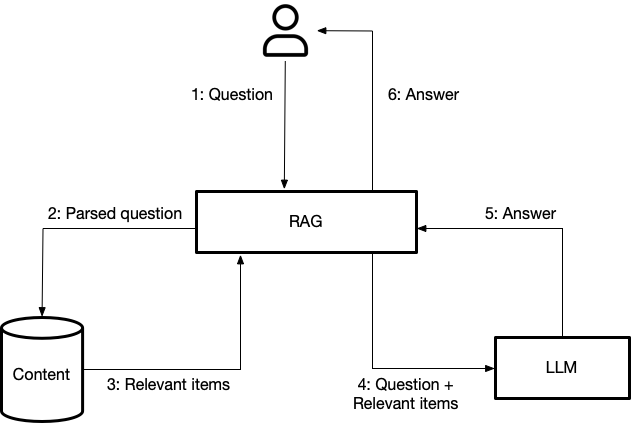

Schematic overview of RAG (source: [What is Retrieval Augmented Generation? An Essential Guide (datasciencedojo.com)](https://datasciencedojo.com/blog/guide-to-retrieval-augmented-generation/))

This doesn’t look too hard, but most examples are (for obvious reasons) based on hugginface GUFF-models. Since we use Keras and Keras_NLP in our classes, I couldn’t find any examples, so I decided to build my own. However, as Keras and Keras_NLP are more aimed at building your own model or doing some low level finetuning, there are to my knowledge no [GUFF models](https://medium.com/@metechsolutions/llm-by-examples-use-gguf-quantization-3e2272b66343) available.I could have decided to build some own quantization method, however this would add an unwanted layer of complexity, and I wanted (for educational purposes) to keep it as simple as possible. So, I decided to leave it as vanilla as possible and take the huge inference time for granted. Anyone who wants to do this for anything else than educational purposes, I would strongly advise using a GUFF-version of the model using [huggingface](https://huggingface.co/models?library=gguf) or something like [ollama](https://ollama.com) (basically a wrapper around llama.cpp). If RAG is the only thing you would like to do with your LLM, I would go with the latter as it does not require hugginface or llama.cpp knowledge.

AAs a start, I needed a subject for my example. While thinking about this, my kid walked in asking questions about which Harry Potter spell to use. So I looked online and found a nice collection of spells and descriptions on [oprahdaily.com](https://www.oprahdaily.com/entertainment/a32598018/harry-potter-spells-list/) (credits to them and of course J.K. Rowling). I just copied the spells and pasted them in a text file. So, now I had my both my subject and my domain specific knowledge about spells.

Next step would be to decide on which semantic database to use. After some searching on the web, I stumbled upon [ChromaDB]( https://www.trychroma.com), which seemed to do the trick. 

After importing the necessary libraries, I read the data and split the lines into three lists. One containing the spells, which would become the metadata; one containing the description of the spells, which would become my documents; and as ChromaDB also needs an ID (and spells are unique), I decided to also use the spell as the ID for this example.

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import os
import string
import chromadb
os.environ["KAGGLE_USERNAME"] = 
os.environ["KAGGLE_KEY"] = 
import warnings
warnings.filterwarnings('ignore')

In [2]:
documents = []
metadata = []
ids = []

with open('spells.txt', 'r', encoding='utf-8') as spells:
    for line in spells:
        line=line.split(" - ") #spells are separated by their description by a " - "
        metadata.append({'spell': line[0]}) #use the spell name as metadata. CromaDB requires a dictionary here
        documents.append(line[1]) #use the description as documents
        ids.append(line[0]) #as we also need an ID, I decided to also use the spell name for that.
print(ids)

['Aberto', 'Accio', 'Aguamenti', 'Alohomora', 'Anapneo', 'Aparecium', 'Apparate', 'Ascendio', '*Avada Kedavra', 'Avis', 'Bat-Bogey Hex', 'Bombardo', 'Brackium Emendo', 'Capacious Extremis', 'Confundo', 'Conjunctivitis Curse', 'Crinus Muto', 'Crucio', 'Diffindo', 'Disillusionment Charm', 'Disapparate', 'Engorgio', 'Episkey', 'Expecto patronum', 'Erecto', 'Evanesco', 'Expelliarmus', 'Ferula', 'Fidelius Charm', 'Fiendfyre Curse', 'Finite Incantatem', 'Furnunculus Curse', 'Geminio', 'Glisseo', 'Homenum Revelio', 'Homonculus Charm', 'Immobulus', 'Impedimenta', 'Incarcerous', 'Imperio', 'Impervius', 'Incendio', 'Langlock', 'Legilimens', 'Levicorpus', 'Locomotor Mortis', 'Lumos', 'Morsmordre', 'Mucus Ad Nauseam', 'Muffliato', 'Nox', 'Obliviate', 'Obscuro', 'Oculus Reparo', 'Oppugno', 'Petrificus Totalus', 'Periculum', 'Piertotum Locomotor', 'Protean Charm', 'Protego', 'Reducto', 'Reducio', 'Renneverate', 'Reparifors', 'Reparo', 'Rictusempra', 'Riddikulus', 'Scourgify', 'Sectumsempra', 'Serpen

As we already have the data in three nice comforting correctly formatted lists, we can start with the ChromaDB part by creating a client, creating a collection, and adding our data to this collection. ChromaDB supports a lot of differen [word embeddings]( https://docs.trychroma.com/guides/embeddings), but for this example de default (all-MiniLM-L6-v2) seems to work fine.

In [3]:
#!pip install chromadb
client = chromadb.Client()

# create or open collection named 'spells' 
spells_collection = client.get_or_create_collection("spells")

# add spells to the collection, ignored for ids that already exist 
spells_collection.add(
    documents=documents,
    metadatas=metadata,
    ids=ids
)

Next we create an user input and query the spells_collection for the best result.

In [4]:
user_input="How do I create light"
results = spells_collection.query(
    query_texts=[user_input],
    n_results=1
)
results

{'ids': [['Lumos']],
 'distances': [[1.3275706768035889]],
 'metadatas': [[{'spell': 'Lumos'}]],
 'embeddings': None,
 'documents': [["Illuminates the caster's wand\n"]],
 'uris': None,
 'data': None}

In [5]:
result=results['metadatas'][0][0]['spell']+" - " + results['documents'][0][0][:-1]
result

"Lumos - Illuminates the caster's wand"

After some cleaning on the results, we can now start with the Keras_NLP part. Recently Keras_NLP integrated kaggle models, so there are quite a number of [models]( https://keras.io/api/keras_nlp/models/) ou can choose from. I tested most of them to find the right balance between inference time and results, finally settling on ‘phi3_mini_4k_instruct_en’ as the sweet spot on my system (M2Pro Mac Mini).

In [6]:
llm = keras_nlp.models.Phi3CausalLM.from_preset("phi3_mini_4k_instruct_en")
llm.backbone.summary()

2024-06-28 10:54:39.360672: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-28 10:54:39.360706: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-28 10:54:39.360711: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-28 10:54:39.360724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-28 10:54:39.360741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Context leak detected, msgtracer returned -1
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Model: "phi3_backbone_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None,      │ 197,001,2… │ token_ids[0][0]   │
│ (ReversibleEmbeddi… │ 32064)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None,      │ 113,252,3… │ token_embedding[… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_2 │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_3 │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_4 │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_5 │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_6 │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_7 │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_8 │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_9 │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None,      │ 113,252,3… │ transformer_laye… │
│ (Phi3Decoder)       │ 3072)             │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None,      │ 113,252,3… │ transformer_laye

 Total params: 3,821,079,552 (14.23 GB)

 Trainable params: 3,821,079,552 (14.23 GB)

 Non-trainable params: 0 (0.00 B)

Now that we have both our ChromaDB results and our model, we can format the prompt and run inference on the model by calling the ‘generate’ method. On apple silicon I had to force the generate methode to run on my CPU to prevent an ugly error.

In [7]:
prompt = """
Recommended spell: {result}
User input: {user_input} 
Suggest a spell based on the recommended spell and the user input."""

prompt=prompt.format(user_input=user_input, result=result)
print ("prompt: ", prompt)
with tf.device('CPU: 0'): #Force on CPU for both apple silicon and low GPU mem configurations
        inference = llm.generate(prompt, max_length = 100)
print(inference)

prompt:  
Recommended spell: Lumos - Illuminates the caster's wand
User input: How do I create light 
Suggest a spell based on the recommended spell and the user input.


2024-06-28 10:55:49.103195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
I0000 00:00:1719564975.196371  105699 service.cc:145] XLA service 0x600000150800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719564975.196670  105699 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1719564975.312089  105699 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Recommended spell: Lumos - Illuminates the caster's wand
User input: How do I create light 
Suggest a spell based on the recommended spell and the user input.
<|assistant|> Based on your request, the spell "Lumos" would be an excellent choice to create light. You can simply say Lumos to illuminate the tip of your wand, allowing you to see in the darkness.<|end|>

Thats’ all folks! Remember, inference takes a long time on non-GUFF models, so please consider something like ollama for more serious purposes.